Instantaneous and delayed deflections on a concrete and composite beam. Obtaining camber of the beam

A concrete beam with a span of L=6.75 m is considered, simply supported and subjected to the following uniformly distributed loads:

- self weight: qpp=12.2 kN/m
- Dead load: qcm=5.2 kN/m
- Live load: qsc=11.7 kN/m

It is considered that 30% of the live load is quasi-permanent (ψ2=0.3)

![beam](EX1&2Beam.png)

The section, 0.35 m wide and 0.50 m heigth, is reinforced with 6Φ20 on the lower face and 3Φ12 on the upper face. For calculation purposes, the cover is 5 cm. The concrete is class C25/30.

The load history is as follows:
- After 14 days, a load equal to the characteristic load is removed and acts on this element.
- After a short time, 70% of the overload is removed, leaving the quasi-permanent charge that is supposed to be maintained indefinitely over time.

As rheological parameters, φ(t,14)=2.5 and εc=0.4 mm/m can be adopted.

It is requested:
1. Determine the total deflection at infinite time due to the quasi-permanent load. To do this, the method of EN 1992-1-1 7.4.3 will be applied and a discretization of the span into 10 parts will be considered.
2. Compare with the results if the equivalent stiffness of the center of the span is considered for the entire span.

In [1]:
from structuralcodes.codes.ec2_2004 import __materials__
from structuralcodes.materials.concrete import ConcreteEC2_2004,ConcreteEC2_2023
from structuralcodes.materials.reinforcement import ReinforcementEC2_2023, ReinforcementEC2_2004
from shapely import Polygon
from structuralcodes.geometry import SurfaceGeometry,CompoundGeometry
from structuralcodes.sections._reinforcement import (
    add_reinforcement,
    add_reinforcement_line,
)
from structuralcodes.sections._generic import GenericSection
from structuralcodes.materials.constitutive_laws import Elastic, ElasticPlastic,ParabolaRectangle,UserDefined
from structuralcodes.plots.section_plots import draw_section
import math
import numpy as np

In [2]:
long_beam = 6.75

# caracteriscic load
qk=12.2 + 5.2 + 11.7 # kN/m
# cuasipermant load
q_cuasip=12.2 + 5.2 + 11.7 * 0.3 # kN/m

eps_cs = 0.4
fi = 2.5

Long-term mechanical properties of the uncracked section:

Ecm = 31476  MPa
Ec_eff = 8993 MPa
Ec = 16667 MPa
Reinf. area = 495 cm2
Sect. area = 1750 cm2
I11_1 = 541390 cm4
cz_1 = 28.06 cm


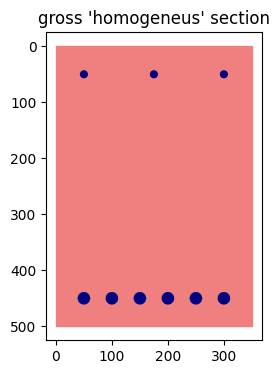

In [3]:
# Materials
concrete = ConcreteEC2_2004(25)
Ec_eff=concrete.Ecm/(1+fi)
Ec = concrete.constitutive_law.get_tangent(0)[0]
print(f"Ecm = {round(concrete.Ecm)}  MPa")
print(f"Ec_eff = {round(Ec_eff)} MPa")
print(f"Ec = {round(Ec)} MPa")

# The package does not compute the Inertia of homogeneus cross secction, so a "concrete reinforfocement" with reinforcement areas multiplied by Es/Ec is used.
reinforcemnet = ReinforcementEC2_2004(fyk=500, Es=Ec, density=7850, ftk=550, epsuk=0.07)   
n=200000/Ec_eff

# Create section
poly = Polygon(((0, 0), (350, 0), (350, 500), (0, 500)))
geo = SurfaceGeometry(poly, concrete)
geo = add_reinforcement_line(geo, (50, 50), (300, 50),12*math.sqrt(n), reinforcemnet, n=3)
geo = add_reinforcement_line(geo, (50, 450), (300, 450), 20*math.sqrt(n) , reinforcemnet, n=6)
sec = GenericSection(geo)
i11_1 = sec.gross_properties.i11
cz_1=sec.gross_properties.cz
print(f"Reinf. area = {round(sec.gross_properties.area_reinforcement/(10**2))} cm2")
print(f"Sect. area = {round(sec.gross_properties.area/(10**2))} cm2")
print(f"I11_1 = {round(i11_1/(10**4))} cm4") 
print(f"cz_1 = {round(cz_1/(10),2)} cm") 

draw_section(sec,"gross 'homogeneus' section",math.sqrt(n))

Mechanical properties of the cracked section at long term:

eps_z0 -2.1936412900686266e-05
x (mm) from z=0: 219.4
I11_2 = 367781 cm4
cz_2 = 21.91 cm


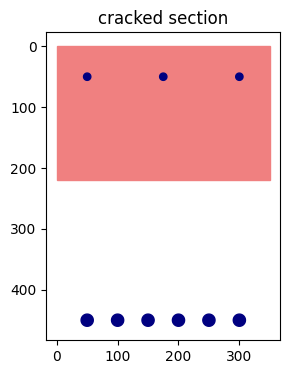

In [4]:
# Get the cracked cross section
curv = 1e-7 # Curvature which produces elastic stresses in the most compressed fibre of the concrete section
eps =  sec.section_calculator.find_equilibrium_fixed_curvature(sec.geometry,0,curv,0)[0]
x=-eps/curv # Distance from the bottom to the neutral fibre
print("eps_z0",eps)
print("x (mm) from z=0:",round(x,1))

# 2) Create the cracked section
poly2 = Polygon(((0, x), (350, x), (350, 0), (0, 0)))
geo2 = SurfaceGeometry(poly2, concrete)
geo2 = add_reinforcement_line(geo2, (50, 50), (300, 50),12*math.sqrt(n), reinforcemnet, n=3)
geo2 = add_reinforcement_line(geo2, (50, 450), (300, 450), 20*math.sqrt(n) , reinforcemnet, n=6)
sec2 = GenericSection(geo2)
i11_2 = sec2.gross_properties.i11
cz_2 = sec2.gross_properties.cz
print(f"I11_2 = {round(i11_2/(10**4))} cm4") 
print(f"cz_2 = {round(cz_2/(10),2)} cm") 
draw_section(sec2,"cracked section",math.sqrt(n))

Calculate the cracking moment:

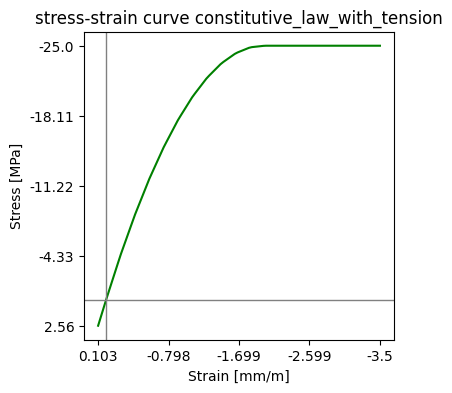

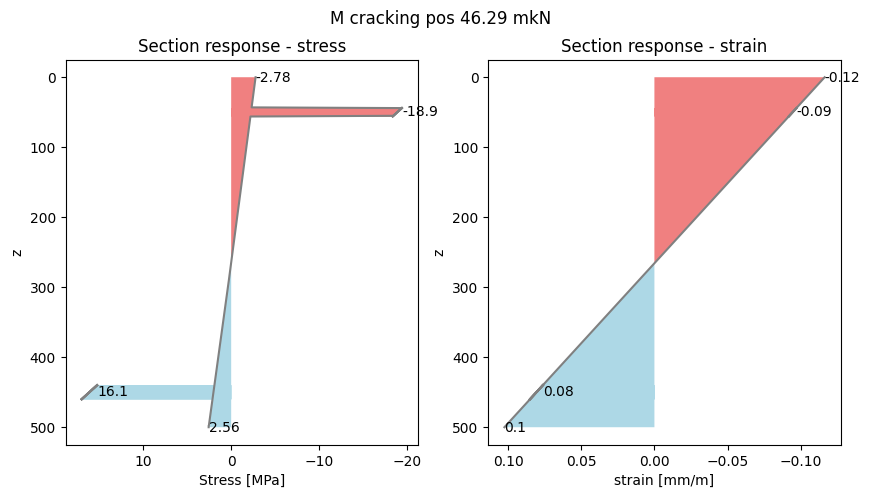

z neutral axis = 265.78


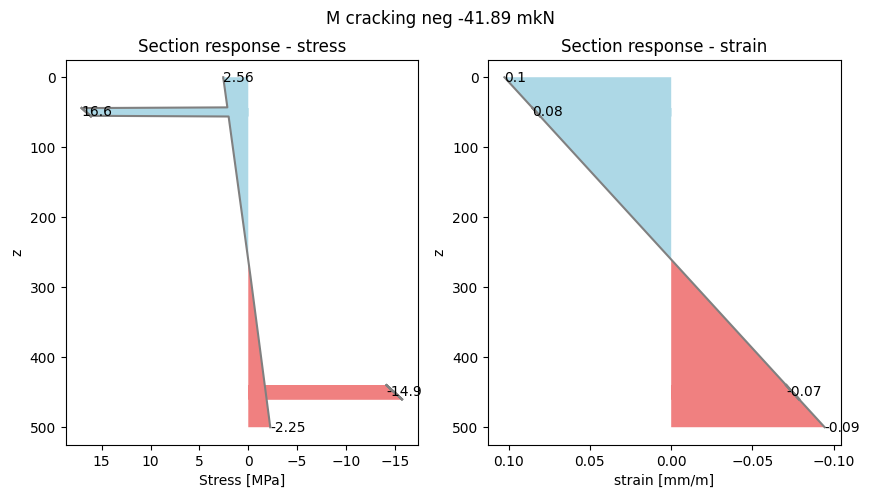

z neutral axis = 260.43
m_cracking (mkN) =  46.29
fctm (MPa) =  2.56


In [11]:
# A concrete material failing at fctm is used for the cracking moment calculation.
concrete = ConcreteEC2_2004(25)
reinforcemnet = ReinforcementEC2_2004(fyk=500, Es=200000, density=7850, ftk=550, epsuk=0.07)   

poly = Polygon(((0, 0), (350, 0), (350, 500), (0, 500)))
geo = SurfaceGeometry(poly, concrete)
geo = add_reinforcement_line(geo, (50, 50), (300, 50),12, reinforcemnet, n=3)
geo = add_reinforcement_line(geo, (50, 450), (300, 450), 20, reinforcemnet, n=6)
sec = GenericSection(geo)

from SLS_section_response import calculate_cracking_moment
m_cracking,_ = calculate_cracking_moment(sec,plot=True)
m_cracking = m_cracking/1e6 #mkN
print('m_cracking (mkN) = ', round(m_cracking,2))
print('fctm (MPa) = ',round(concrete.fctm,2))

Checking deflections by calculation according to EN 1992 1-1 section 7.4.3

Expresion 7.18:
$$\alpha = \zeta\alpha_{II} + (1-\zeta)\alpha_{I}$$
$$(1/r) = \zeta(1/r)_{II} + (1-\zeta)(1/r)_{I}$$
where  $(1/r)_{II}$ is the curvature of the fully cracked seciont and $(1/r)_{I}$ is the curvature of the uncracked section 
Expresion 7.19:
$$
\zeta = 1 - \beta(M_{cr}/M) ^2  
$$
where  $\beta=0.5$ for sustained loads 


In [13]:
def bending_momment_x_beam(q,L,n_sections=11): # n_sections -> number of sections in the beam
    """Return M for a simply supported beam under a uniform load q."""
    x = np.linspace(0,L,n_sections)
    # Maximum deflection at the centre of the span. Only the first half of the sections are required
    x = x[:math.ceil(n_sections/2)] 
    m_x=q*x/2*(L-x)
    return x,m_x

def compute_zeta_expresion_7_19(m_cracking,m_x):
    """Expresion 7.19 EN 1992 1-1."""
    zeta = 1-0.5*(m_cracking/m_x)**2
    zeta[m_x == 0] = 0
    return zeta

def compute_curvature(m_x,E,I):
    """Return the curvature in n sections given the moments in each section."""
    return m_x/(E*1000*I/1000**4)

x_beam,m_x_characteristic = bending_momment_x_beam(qk,long_beam)
x_beam,m_x_cuaisp = bending_momment_x_beam(q_cuasip,long_beam)

zeta =compute_zeta_expresion_7_19(m_cracking,m_x_characteristic)
curv_1 = compute_curvature(m_x_cuaisp,Ec_eff,i11_1)
curv_2 = compute_curvature(m_x_cuaisp,Ec_eff,i11_2)

# Expresion 7.18
curv = zeta*curv_2 + (1-zeta)*curv_1

# curvature integration
deflection = np.trapz(curv*x_beam*1000,x_beam)


print('Maximum deflection [mm] =', round(deflection,2))




C:\Users\cmg\AppData\Local\Temp\ipykernel_29892\3607814390.py:11: RuntimeWarning: divide by zero encountered in divide
  zeta = 1-0.5*(m_cracking/m_x)**2


Maximum deflection [mm] = 16.89


Shrinkage deflections :

Expresion 7.21:  
$
1/r_{cs} = \epsilon_{cs}\alpha_e  S/I   
$

In [14]:
a_fi20 = math.pi * 20**2/4
a_fi12 = math.pi * 12**2/4
s_1 = (6*a_fi20 * (450-cz_1) + 3*a_fi12 * (50-cz_1))
s_2 = (6*a_fi20 * (450-cz_2) + 3*a_fi12 * (50-cz_2))
s_= zeta*s_2 + (1-zeta)*s_1
i_= zeta*i11_2 + (1-zeta)*i11_1
print('S_I (mm3)= ',round(s_1))
print('S_II (mm3)= ',round(s_2))
#print("S = ",s_)
print('I_I (mm4)= ',round(i11_1))
print('I_II (mm4)= ',round(i11_2))
#print("I = ",i_)
curv_cs = eps_cs * n * s_/i_ 

# curvature integration
deflection_cs = np.trapz(curv_cs*x_beam*1000,x_beam)
print('Shrinkage deflection [mm] =', round(deflection_cs,2))
print('Total deflection [mm] =', round(deflection+deflection_cs,2))

S_I (mm3)=  241009
S_II (mm3)=  377817
I_I (mm4)=  5413898904
I_II (mm4)=  3677810527
Shrinkage deflection [mm] = 4.9
Total deflection [mm] = 21.8


2. Compare with the results if the equivalent stiffness of the center of the span is considered for the entire span.

$$
f = 5/384  qL^4/EI
$$

In [15]:
def_1 = 5/384*q_cuasip*long_beam**4 / (Ec_eff*1000) / (i11_1/1000**4) *1000
def_2 = 5/384*q_cuasip*long_beam**4 / (Ec_eff*1000) / (i11_2/1000**4) *1000
zeta_ = 1-0.5*(m_cracking/(qk*long_beam**2/8))**2
def_ =  zeta_*def_2 + (1-zeta_)*def_1
deflection_cs = eps_cs * n * s_[-1]/i_[-1] * long_beam**2 /8 *1000

print ('zeta = ', round(zeta_,2))
print()
print ('CUSIPERMANTENT LOAD DEFLECTION:') 
print ('deflection I (mm) = ', round(def_1,2))
print ('deflection II (mm) = ', round(def_2,2))
print ('deflection cuasip (mm) = ', round(def_,2))
print()
print ('SHRINKAGE DEFLECTION:') 
print ('deflection_cs (mm) = ', round(deflection_cs,2))
print()
print ('TOTAL DEFLECTION:') 
print ('deflection (mm) = ', round(def_ + deflection_cs,2))

zeta =  0.96

CUSIPERMANTENT LOAD DEFLECTION:
deflection I (mm) =  11.61
deflection II (mm) =  17.09
deflection cuasip (mm) =  16.88

SHRINKAGE DEFLECTION:
deflection_cs (mm) =  5.04

TOTAL DEFLECTION:
deflection (mm) =  21.91
